In [1]:
import os
%matplotlib inline
os.environ["THEANO_FLAGS"] = "device=cpu,exception_verbosity=high"
import theano.tensor as T
from collections import OrderedDict
from lasagne import init, updates , layers
w, h = 28, 28
import theano

In [2]:
import glob
import os
from skimage.io import imread
import pandas as pd
import numpy as np
from skimage.transform import resize
inputs = []
outputs = []
outputs_non_normalized = []
x_min = []
x_max = []
y_min = []
y_max = []
for filename in glob.glob("png/*.png"):
    inp = resize(imread(filename), (w, h)).tolist()
    inputs.append(inp)
    name = (os.path.splitext(os.path.basename(filename))[0])
    filename_txt = "svg/{0}.svg.txt".format(name)
    df = pd.read_table(filename_txt, skiprows=1, 
                       sep=' ',
                       names=["p1x", "p1y", "p2x", "p2y", "p3x", "p3y", "p4x", "p4y"])
    #df.loc[len(df)] = [-1] * 8
    o = df.values.copy().astype(np.float32)
    
    outputs_non_normalized.append(o.copy())
    
    
    s = slice(0, len(o))
    m = (0, 2, 4, 6)
    x_min.append(o[s, m].min())
    x_max.append(o[s, m].max())
    o[s, m] -= o[s, m].min()
    o[s, m] /= o[s, m].max()
    
    m = (1, 3, 5, 7)
    y_min.append(o[s, m].min())
    y_max.append(o[s, m].max())
    o[s, m] -= o[s, m].min()
    o[s, m] /= o[s, m].max()
    
    #o = np.concatenate( (np.zeros((1, 8)), o), axis=0)    
    #o =  o[1:, :] - o[0:-1, :]
    o = np.concatenate( (np.zeros((1, 8)), o), axis=0)
    o = np.concatenate( (o, np.zeros((1, 8))), axis=0)
    o = o.astype(np.float32)
    #o=o*2-1
    outputs.append(o)

inputs = np.array(inputs).astype(np.float32)
inputs /= 255.
inputs = 1 - inputs
inputs = inputs.reshape((inputs.shape[0], w*h))

/home/mehdi/anaconda/envs/py35/lib/python3.4/site-packages/PIL/Image.py:861: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/mehdi/anaconda/envs/py35/lib/python3.4/site-packages/PIL/Image.py:861: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/mehdi/anaconda/envs/py35/lib/python3.4/site-packages/PIL/Image.py:861: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/mehdi/anaconda/envs/py35/lib/python3.4/site-packages/PIL/Image.py:861: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home/mehdi/anaconda/envs/py35/lib/python3.4/site-packages/PIL/Image.py:861: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/home

In [8]:
v = [o.shape[0] for o in outputs]
from collections import Counter
c = Counter(v)
c

Counter({5: 4,
         6: 1,
         7: 3,
         8: 12,
         9: 6,
         10: 7,
         11: 14,
         12: 11,
         13: 7,
         14: 10,
         15: 6,
         16: 19,
         17: 31,
         18: 20,
         19: 7,
         20: 16,
         21: 15,
         22: 14,
         23: 15,
         24: 13,
         25: 18,
         26: 25,
         27: 13,
         28: 9,
         29: 12,
         30: 10,
         31: 5,
         32: 14,
         33: 7,
         34: 15,
         35: 7,
         36: 7,
         37: 7,
         38: 4,
         39: 2,
         40: 3,
         41: 1,
         42: 1,
         44: 4,
         45: 2,
         46: 2,
         47: 2,
         48: 1,
         49: 1,
         50: 2,
         51: 1,
         52: 2,
         53: 1,
         54: 1,
         55: 2,
         57: 2,
         58: 2,
         65: 1,
         66: 1,
         68: 1,
         70: 1,
         72: 1,
         81: 1,
         88: 1})

In [4]:
from lasagne.layers import Layer
class RepeatLayer(Layer):
    
    def __init__(self, incoming, shape, desired_shape, **kwargs):
        super(RepeatLayer, self).__init__(incoming, **kwargs)
        self.shape = shape
        self.desired_shape = desired_shape
        
    def get_output_for(self, input, **kwargs):
        input_ = input.dimshuffle(*self.desired_shape)
        return input_ * T.ones(self.desired_shape)
    
    def get_output_shape_for(self, input_shape):
        return [b if a == 'x' else input_shape[a] 
                for a, b in zip(self.shape, self.desired_shape)]

class StepLayer(Layer):
    def __init__(self, incoming, iteration_layer, **kwargs):
        super(StepLayer, self).__init__(incoming, **kwargs)
        self.iteration_layer = iteration_layer
    
    def get_output_for(self, input, **kwargs):
        
        def step(input_i):
            return layers.get_output(self.iteration_layer, input_i)
        sequences = [input]
        return theano.scan(fn=step, sequences=sequences, 
                           outputs_info=None,
                           strict=False)[0]
    
    def get_output_shape_for(self, input_shape):
        return tuple([input_shape[0]] + list(self.iteration_layer.output_shape))

In [5]:
import lasagne.layers
from lasagne.layers import Gate
from lasagne.init import HeUniform
from lasagnekit.generative.capsule import Capsule
from lasagnekit.easy import LightweightModel, BatchOptimizer
n_in = 8
n_hid = 800
size_mixture = 20
n_out = 8 * 2 * size_mixture + size_mixture
nb_layers = 2
l_in = lasagne.layers.InputLayer((None, None, n_in))
l_rec = l_in
for i in range(nb_layers):
    l_rec = lasagne.layers.LSTMLayer(l_rec, n_hid, grad_clipping=10)
    #l_rec = lasagne.layers.RecurrentLayer(l_rec, n_hid, 
    #                                      W_in_to_hid=HeUniform(), 
    #                                      grad_clipping=10,
    #                                      W_hid_to_hid=HeUniform())

l_out = lasagne.layers.LSTMLayer(l_rec, n_out, grad_clipping=10, 
                                 nonlinearity=lasagne.nonlinearities.linear)
#l_out = lasagne.layers.RecurrentLayer(l_rec, n_out, 
#                                      W_in_to_hid=HeUniform(),
#                                      W_hid_to_hid=HeUniform(),
#                                      grad_clipping=10,
#                                      nonlinearity=lasagne.nonlinearities.linear)
model = LightweightModel([l_in], [l_out])

/home/mehdi/work/code/scikit-learn/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.19.
  "This module will be removed in 0.19.", DeprecationWarning)


In [6]:
input_variables = OrderedDict()
input_variables["X"] = dict(tensor_type=T.tensor3)
input_variables["y"] = dict(tensor_type=T.tensor3)

In [7]:
from lasagnekit.easy import log_sum_exp

def softmax(x, axis=1):
    e_x = T.exp(x - x.max(axis=axis, keepdims=True))
    out = e_x / e_x.sum(axis=axis, keepdims=True)
    return out
    
class MyBatchOptimizer(BatchOptimizer):
    
    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        return status
    
batch_optimizer = MyBatchOptimizer(
    verbose=1,
    max_nb_epochs=1000,
    batch_size=1,
    optimization_procedure=(updates.rmsprop, 
                            {"learning_rate": 0.0001}),
)

def gaussian_ll(X, x_mean_hat, x_log_sigma_hat):
    # x_mean_hat and x_sigma_hat computed by a neural network
    x_hat = X - x_mean_hat
    ll = -0.5 * ((x_hat ** 2) / T.exp(2. * x_log_sigma_hat) + 2 * x_log_sigma_hat) - 0.5*np.log(2*np.pi)
    return ll

def extract_from_y_dist(y_dist):
    y_dist_mixtures =    y_dist[:, :, 0:size_mixture*8*2]
    y_dist_mixtures = y_dist_mixtures.reshape((y_dist_mixtures.shape[0], 
                                               y_dist_mixtures.shape[1], 
                                               size_mixture, 2, 8))
    y_mean = T.tanh(y_dist_mixtures[:, :, :, 0, :])
    y_std = T.exp(y_dist_mixtures[:, :, :, 1, :])
    
    #100, 25, 7, 8
    y_dist_proportions = y_dist[:, :, size_mixture*8*2:]
    y_dist_proportions = y_dist_proportions.reshape((y_dist_proportions.shape[0],
                                                     y_dist_proportions.shape[1],
                                                     size_mixture,
                                                    ))
    # 100, 25, 7
    y_dist_proportions = softmax(y_dist_proportions, axis=2)
    return y_mean, y_std, y_dist_proportions





def loss_function(model, tensors):
    tx = tensors["X"]
    ty = tensors["y"]
    
    x = tx
    y_dist, = model.get_output(x)
    #8 means, 8 stds for each mixture
    
    y_mean, y_std, y_dist_proportions = extract_from_y_dist(y_dist)

    #y_mean : 100, 25, 7, 8
    #y_std  : 100, 25, 7, 8
    #dist_proportions : 100, 25, 7, 8
    # y     : 100, 25, 8
    
    y_ = ty.dimshuffle(0, 1, 'x', 2)
    
    #100, 25, 7
    per_mixture = gaussian_ll(y_, y_mean, y_std).sum(axis=3) + T.log(y_dist_proportions)
    #100, 25, 7
    per_example_and_time = log_sum_exp(per_mixture, axis=2)
    per_example = per_example_and_time.sum(axis=1).mean()
    return -per_example

functions = dict(
    encode=dict(
        get_output=lambda model, X:model.get_output(X)[0],
        params=["X"]
    ),
    extract_from_y_dist=dict(
        get_output=lambda model, X: extract_from_y_dist(model.get_output(X)[0]),
        params=["X"]
    )
)

capsule = Capsule(
    input_variables, 
    model,
    loss_function,
    functions=functions,
    batch_optimizer=batch_optimizer,
)

In [8]:
outputs_normal = [o[0:-1] for o in outputs]
outputs_shifted = [o[1:] for o in outputs]

In [ ]:
capsule.fit(X=outputs_normal, y=outputs_shifted)

In [ ]:
from lasagnekit.easy import get_stat
import matplotlib.pyplot as plt
plt.plot(get_stat("loss_train", capsule.batch_optimizer.stats))

In [ ]:
#np.abs(capsule.encode(inputs[0:1])-outputs[0])

In [9]:
template = """
<svg version="1.0" width="300" height="300"
     xmlns="http://www.w3.org/2000/svg" 
     xmlns:xlink="http://www.w3.org/1999/xlink">
     {0}
</svg> 
"""
path_template = """"<path d="M {x1},{y1} C {cx},{cy} {x2},{y2} {x3},{y3}" 
                          stroke-width="5" style="fill:none;stroke:black;"/>"""

def gen_path(x1, y1, cx, cy, x2, y2, x3, y3):
    return path_template.format(x1=x1, y1=y1, cx=cx, cy=cy, x2=x2, y2=y2, x3=x3, y3=y3)
def gen_svg_from_output(output):
    o = output.copy()
    o[:, (0, 2, 4, 6)] *= 200
    o[:, (0, 2, 4, 6)] += 50
    o[:, (1, 3, 5, 7)] *= 200
    o[:, (1, 3, 5, 7)] += 50
    assert output.shape[1] == 8
    s = ""
    for out in o:
        s += gen_path(*out) + "\n"
    return template.format(s)


In [10]:
def generate(model, initial=None, nb_steps=1):
    if initial is None:
        initial = np.zeros((8,)).astype(np.float32)
    generated = np.zeros((1, nb_steps + 1, 8)).astype(np.float32)
    generated[0, 0] = initial
    # (one example, one time step, 8)
    x = initial[None, None, :]
    for i in range(1, nb_steps):
        y_mean, y_std, y_dist_proportions = model.extract_from_y_dist(generated[:, 0:i, :])
        y_dist_proportions = y_dist_proportions[0, i - 1] #** 0.1
        
        mixture_id = y_dist_proportions.argmax()
        y_dist_proportions[-1] = 1 - y_dist_proportions[0:-1].sum()
        #mixture_id = np.random.multinomial(1, y_dist_proportions).argmax()
        y_mean = y_mean[0, i - 1, mixture_id]
        y_std = y_std[0, i - 1, mixture_id]
        y_gen = np.random.multivariate_normal(y_mean, (np.diag(y_std**2)))
     
        #generated[i] = outputs[0][i]
        generated[0, i, :] = y_gen# + generated[0, i - 1, :]
        
    return generated[0]

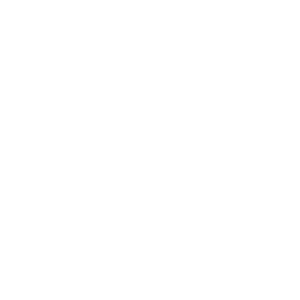

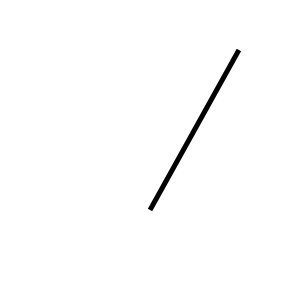

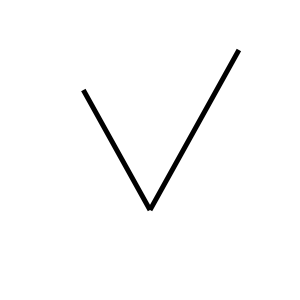

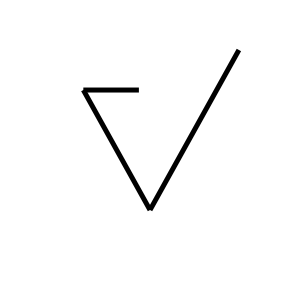

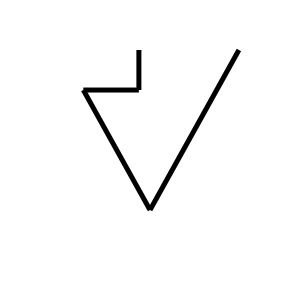

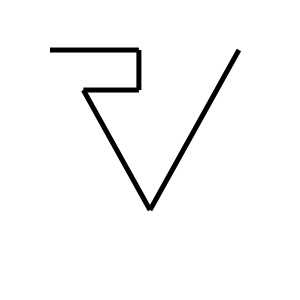

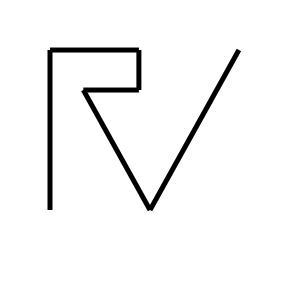

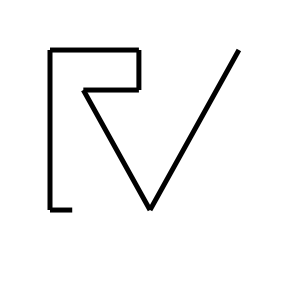

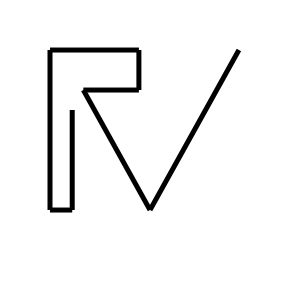

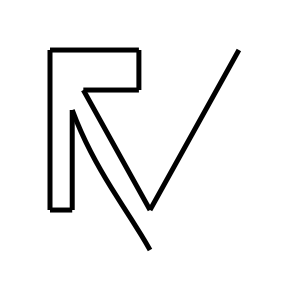

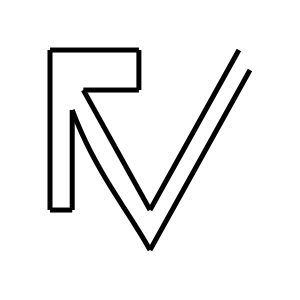

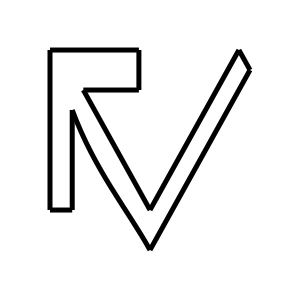

In [16]:
from IPython.display import SVG, display
from IPython.core.display import display_svg
for i in range(1):
    o = outputs_normal[1].copy()
    #o = generate(capsule, nb_steps=25)
    
    #o[1:] += o[0:-1]
    
    #break
    for k in range(len(o)):
        display_svg(SVG(data=gen_svg_from_output(o[0:k + 1])))